In [861]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import time
from matplotlib.table import Table

In [862]:
class Graph:
    def __init__(self, num_nodes, positions):
        self.num_nodes = num_nodes
        self.positions = positions

    def get_distance(self, u, v):
        x1, y1 = self.positions[u]
        x2, y2 = self.positions[v]
        return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def get_all_pairs_distances(self):
        dist_matrix = np.zeros((self.num_nodes, self.num_nodes))
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                dist = self.get_distance(i, j)
                dist_matrix[i][j] = dist_matrix[j][i] = dist

        return dist_matrix

## Brute-Force Algorithm
The brute-force algorithm considers all possible combinations of `k` centers in the graph. 
It calculates the radius for each combination and selects the one with the smallest maximum radius. 
While it guarantees the optimal solution, it has a high computational cost, making it impractical for large graphs.

In [863]:
def brute_force_k_center(graph, k):
    dist_matrix = graph.get_all_pairs_distances()
    best_centers = None
    min_radius = float('inf')

    for centers in itertools.combinations(range(graph.num_nodes), k):
        
        max_distance = 0
        for node in range(graph.num_nodes):
            min_distance_to_center = min(dist_matrix[node][center] for center in centers)
            max_distance = max(max_distance, min_distance_to_center)

        # Apdejtuje najbolji centar
        if max_distance < min_radius:
            min_radius = max_distance
            best_centers = centers

    return best_centers, min_radius

## Greedy Algorithm
The greedy algorithm iteratively selects the next center to maximize the minimum distance to the closest existing center. 
While faster than brute force, it does not guarantee the optimal solution. It's a heuristic approach that often provides reasonably good results.

In [864]:
def greedy_k_center(graph, k):
    dist_matrix = graph.get_all_pairs_distances()
    centers = []
    remaining_nodes = set(range(graph.num_nodes))

    # Bira random centar
    centers.append(remaining_nodes.pop())
    
    while len(centers) < k:
        max_min_dist = -1
        next_center = None
        for node in remaining_nodes:
            min_dist_to_center = min(dist_matrix[node][center] for center in centers)
            if min_dist_to_center > max_min_dist:
                max_min_dist = min_dist_to_center
                next_center = node

        centers.append(next_center)
        remaining_nodes.remove(next_center)

    radius = 0
    for node in range(graph.num_nodes):
        min_distance_to_center = min(dist_matrix[node][center] for center in centers)
        radius = max(radius, min_distance_to_center)

    return centers, radius

## Genetic Algorithm
This metaheuristic uses a population of solutions, evolves them over generations, and applies selection, crossover, and mutation. 
The goal is to minimize the radius. While it does not guarantee the optimal solution, it is effective for large and complex graphs.

In [865]:
def genetic_k_center(graph, k, population_size=50, generations=100, mutation_rate=0.1):
    dist_matrix = graph.get_all_pairs_distances()

    def fitness(individual):
        radius = 0
        for node in range(graph.num_nodes):
            min_distance_to_center = min(dist_matrix[node][center] for center in individual)
            radius = max(radius, min_distance_to_center)
        return radius

    def create_individual():
        return random.sample(range(graph.num_nodes), k)

    def mutate(individual):
        if random.random() < mutation_rate:
            idx_to_replace = random.randint(0, k - 1)
            new_node = random.choice([node for node in range(graph.num_nodes) if node not in individual])
            individual[idx_to_replace] = new_node

    def crossover(parent1, parent2):
        split = random.randint(1, k - 1)
        child = parent1[:split] + [node for node in parent2 if node not in parent1[:split]]
        return child[:k]

    # Initialize population
    population = [create_individual() for _ in range(population_size)]

    for _ in range(generations):
        population.sort(key=fitness)
        next_generation = population[:population_size // 2]

        while len(next_generation) < population_size:
            parent1, parent2 = random.sample(population[:population_size // 2], 2)
            child = crossover(parent1, parent2)
            mutate(child)
            next_generation.append(child)

        population = next_generation

    best_individual = min(population, key=fitness)
    best_radius = fitness(best_individual)

    return best_individual, best_radius

## K-Means Heuristic
This algorithm starts with random centers and iteratively refines them by grouping nodes into clusters based on proximity. 
It recalculates centers based on the cluster's mean position. It's fast and effective but does not guarantee an optimal solution.

In [866]:
def compute_radius(graph, centers, dist_matrix):
    
    radius = 0
    
    for node in range(graph.num_nodes):
        min_distance_to_center = min(dist_matrix[node][center] for center in centers)
        radius = max(radius, min_distance_to_center)

    return radius

def k_means_heuristic(graph, k, iterations=100):
    centers = random.sample(range(graph.num_nodes), k)
    dist_matrix = graph.get_all_pairs_distances()

    for _ in range(iterations):
        clusters = {center: [] for center in centers}

        for node in range(graph.num_nodes):
            closest_center = min(centers, key=lambda center: dist_matrix[node][center])
            clusters[closest_center].append(node)

        new_centers = []
        for center, nodes in clusters.items():
            if nodes:
                avg_x = sum(graph.positions[node][0] for node in nodes) / len(nodes)
                avg_y = sum(graph.positions[node][1] for node in nodes) / len(nodes)
                closest_node = min(nodes, key=lambda node: np.sqrt((graph.positions[node][0] - avg_x)**2 + (graph.positions[node][1] - avg_y)**2))
                new_centers.append(closest_node)

        if set(new_centers) == set(centers):
            break

        centers = new_centers

    return centers, compute_radius(graph, centers, dist_matrix)

## Simulated Annealing Algorithm
Simulated annealing explores the solution space by introducing random variations. 
It accepts worse solutions with a probability depending on the current temperature, allowing it to escape local minima. 
The temperature decreases over time until the algorithm converges.

In [867]:
def simulated_annealing_k_center(graph, k, initial_temp=1000, cooling_rate=0.995, min_temp=1e-4):

    dist_matrix = graph.get_all_pairs_distances()  # Get the distance matrix

    # Randomly initialize the centers
    centers = random.sample(range(graph.num_nodes), k)
    current_radius = compute_radius(graph, centers, dist_matrix)  # Compute the initial radius using the distance matrix
    best_centers = list(centers)
    best_radius = current_radius

    temp = initial_temp

    while temp > min_temp:
        # Generate a neighboring solution by swapping a center
        new_centers = centers[:]
        i = random.randint(0, k - 1)
        new_node = random.choice([node for node in range(graph.num_nodes) if node not in new_centers])
        new_centers[i] = new_node

        # Compute the radius of the new solution
        new_radius = compute_radius(graph, new_centers, dist_matrix)  # Compute the radius using the distance matrix

        # Accept the new solution if it's better or with some probability if it's worse
        if new_radius < current_radius or random.random() < math.exp((current_radius - new_radius) / temp):
            centers = new_centers
            current_radius = new_radius

            # Update the best solution
            if current_radius < best_radius:
                best_centers = centers
                best_radius = current_radius

        # Decrease the temperature
        temp *= cooling_rate

    return best_centers, best_radius

## Ant Colony Optimization Algorithm
Ant colony optimization mimics the behavior of ants finding paths to food. 
Ants deposit pheromones on paths, influencing the probability of future ants selecting those paths. 
The algorithm iteratively reinforces paths leading to good solutions and evaporates weaker paths.

In [868]:
def ant_colony_k_center(graph, k, num_ants=10, iterations=50, evaporation_rate=0.7, pheromone_boost=3.0):
    dist_matrix = graph.get_all_pairs_distances()

    # Initialize pheromone matrix
    pheromone = np.ones((graph.num_nodes, graph.num_nodes))

    def choose_centers():
        centers = set()
        probabilities = pheromone.sum(axis=0)
        probabilities /= probabilities.sum()
        while len(centers) < k:
            chosen = np.random.choice(range(graph.num_nodes), p=probabilities)
            centers.add(chosen)
        return list(centers)

    def update_pheromone(centers, radius):
        for i in centers:
            for j in range(graph.num_nodes):
                pheromone[i][j] += pheromone_boost / radius

    best_centers = None
    best_radius = float('inf')

    for _ in range(iterations):
        for _ in range(num_ants):
            centers = choose_centers()
            radius = compute_radius(graph, centers, dist_matrix)

            if radius < best_radius:
                best_radius = radius
                best_centers = centers

            update_pheromone(centers, radius)

        # Evaporation
        pheromone *= (1 - evaporation_rate)

    return best_centers, best_radius


In [869]:
def visualize_graph(graph, centers, radius, title, color):

    pos = graph.positions
    x, y = zip(*pos)

    # Move overlapping nodes slightly apart
    def adjust_positions(positions, threshold=0.5):
        for i in range(len(positions)):
            for j in range(i + 1, len(positions)):
                xi, yi = positions[i]
                xj, yj = positions[j]
                dist = np.sqrt((xi - xj) ** 2 + (yi - yj) ** 2)
                if dist < threshold:  # If nodes are too close, move them apart
                    offset = threshold - dist
                    angle = np.arctan2(yj - yi, xj - xi)
                    # Move nodes away from each other along the line connecting them
                    positions[i] = (xi - offset * np.cos(angle), yi - offset * np.sin(angle))
                    positions[j] = (xj + offset * np.cos(angle), yj + offset * np.sin(angle))

    adjusted_positions = pos.copy()
    adjust_positions(adjusted_positions)
    x, y = zip(*adjusted_positions)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(x, y, s=100, c='lightblue', label="Nodes", edgecolors='black', zorder=5)

    # Annotate nodes
    for i, (xi, yi) in enumerate(adjusted_positions):
        ax.text(xi, yi, str(i), fontsize=8, ha='center', va='center', zorder=10)

    # Draw circles for each center
    for center in centers:
        xi, yi = adjusted_positions[center]
        circle = plt.Circle((xi, yi), radius, color=color, fill=True, alpha=0.2, linewidth=2)
        ax.add_artist(circle)

    # Add title to the plot with space for radius label
    ax.set_title(title, fontsize=14, pad=15)

    # Add radius label above the title
    ax.text(0.5, 1.08, f"Radius: {radius:.2f}", fontsize=12, color='darkred', alpha=0.7,
            ha='center', va='center', transform=ax.transAxes)

    ax.set_aspect('equal')
    ax.set_xlim(min(x) - radius, max(x) + radius)
    ax.set_ylim(min(y) - radius, max(y) + radius)
    plt.show()


In [870]:
def measure_execution_time_and_radius_random_graphs(num_graphs, num_nodes, k, algorithms, position_range, time_limit=1):
    execution_times = {name: [] for name in algorithms}
    radius_results = {name: [] for name in algorithms}

    for _ in range(num_graphs):
        # Generate a random graph with positions in the specified range
        min_value, max_value = position_range
        positions = [(random.randint(min_value, max_value), random.randint(min_value, max_value)) for _ in range(num_nodes)]
        graph = Graph(num_nodes, positions)

        for name, algo in algorithms.items():
            if num_graphs > 10 and name == "Brute-Force":
                # Skip Brute-Force if num_graphs > 10 as it is too long
                continue

            start_time = time.time()
            centers, radius = algo(graph, k)
            end_time = time.time()

            execution_times[name].append(end_time - start_time)
            radius_results[name].append(radius)

    return execution_times, radius_results


In [871]:
def plot_execution_times(execution_times, num_graphs):
    # Mean times for all algorithms
    mean_times = {name: np.mean(times) for name, times in execution_times.items()}

    # Plot all algorithms in one bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(mean_times.keys(), mean_times.values(), color="skyblue", label="Execution Times")
    plt.xlabel("Algorithms")
    plt.ylabel("Mean Execution Time (s)")
    plt.title(f"Mean Execution Time over {num_graphs} Random Graphs")
    plt.grid(True)
    plt.show()


In [872]:
def plot_radius_results(radius_results, num_graphs):
    # Handle empty results gracefully
    plt.figure(figsize=(12, 6))
    for name, radii in radius_results.items():
        if not radii:  # Skip empty results
            continue
        plt.plot(range(1, num_graphs + 1), radii, label=name, marker='o', linestyle='--')
    plt.xlabel("Graph Index")
    plt.ylabel("Radius")
    plt.title("Radius Results for All Algorithms")
    plt.legend()
    plt.show()


In [873]:
def plot_time_vs_radius(execution_times, radius_results, title="Time vs. Radius for Algorithms"):
    plt.figure(figsize=(10, 6))
    
    for algo_name in execution_times.keys():
        # Skip "Brute-Force" if its radius results are empty
        if algo_name == "Brute-Force" and not radius_results.get(algo_name):
            continue
        
        times = execution_times[algo_name]
        radii = radius_results[algo_name]
        plt.scatter(radii, times, label=algo_name, s=100, alpha=0.7)

    plt.xlabel("Radius")
    plt.ylabel("Execution Time (s)")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


In [874]:
def calculate_best_algorithm(radius_results, execution_times, time_limit=1.0):
    # Initialize scores
    scores = {}

    # Get valid algorithms by filtering out those with invalid (None or empty) results
    valid_algorithms = [
        algo for algo in radius_results
        if radius_results.get(algo) and execution_times.get(algo) 
        and len(radius_results[algo]) > 0 and len(execution_times[algo]) > 0
    ]

    if not valid_algorithms:  # If no valid algorithms remain, return None and empty scores
        return None, {}

    # Normalize execution times
    all_radii = [np.mean(radius_results[algo]) if len(radius_results[algo]) > 0 else float('inf') for algo in valid_algorithms]
    all_times = [np.mean(execution_times[algo]) if len(execution_times[algo]) > 0 else float('inf') for algo in valid_algorithms]

    min_radius, max_radius = min(all_radii), max(all_radii)
    
    # Adjust radius range
    min_radius_adj = min_radius - 0.1
    max_radius_adj = max_radius + 0.1

    for algo in valid_algorithms:
        # Safely calculate mean values
        mean_time = np.mean(execution_times[algo]) if len(execution_times[algo]) > 0 else float('inf')
        mean_radius = np.mean(radius_results[algo]) if len(radius_results[algo]) > 0 else float('inf')

        if mean_time > time_limit:
            scores[algo] = 1.0  # Disqualify by setting score to 1
        else:
            # Map radius to [0, 1] based on adjusted range
            normalized_radius = (mean_radius - min_radius_adj) / (max_radius_adj - min_radius_adj or 1)
            scores[algo] = normalized_radius

    # Identify algorithms with the same scores
    score_to_algorithms = {}
    for algo, score in scores.items():
        score_to_algorithms.setdefault(score, []).append(algo)

    for score, algos in score_to_algorithms.items():
        if len(algos) > 1:  # Resolve ties
            tied_times = [np.mean(execution_times[algo]) if len(execution_times[algo]) > 0 else float('inf') for algo in algos]
            min_time, max_time = min(tied_times), max(tied_times)

            for algo, time in zip(algos, tied_times):
                normalized_time = (time - min_time) / (max_time - min_time or 1)
                scores[algo] += normalized_time / 100

    # Find the algorithm with the lowest score
    best_algorithm = min(scores, key=scores.get)
    return best_algorithm, scores


In [875]:
def plot_table(data, title, best_algorithm):
    # Replace 'inf' with '-'
    for i in range(len(data)):
        for j in range(len(data[i])):
            if data[i][j] == float('inf'):
                data[i][j] = '-'  # Replace 'inf' with '-'

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(12, 4))

    # Hide axes
    ax.axis('off')

    # Define column labels
    col_labels = ["Algorithm", "Min Radius", "Max Radius", "Mean Radius", "Min Time", "Max Time", "Mean Time"]

    # Create table
    table = ax.table(cellText=data, colLabels=col_labels, loc='center')

    # Style table (optional)
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)  # Scale table for better readability

    # Apply background color to header row
    for (i, j), cell in table.get_celld().items():
        if i == 0:
            cell.set_text_props(fontweight='bold', color='white')  # Header text bold and white
            cell.set_facecolor('#3E8E41')  # Dark green header background
        else:
            # Apply alternating row colors
            if i % 2 == 0:
                cell.set_facecolor('#F4F4F4')  # Light gray
            else:
                cell.set_facecolor('#FFFFFF')  # White

            # Style numbers with two decimal places
            if isinstance(cell.get_text(), str) and cell.get_text().replace('.', '', 1).isdigit():
                cell.set_text_props(fontweight='normal', color='black')
            else:
                cell.set_text_props(fontweight='normal', color='black')

    # Highlight the best algorithm row
    for i, row in enumerate(data):
        if row[0] == best_algorithm:
            for j in range(len(row)):
                cell = table[(i + 1, j)]  # Adjusted for table's 0-based indexing
                cell.set_text_props(fontweight='bold')

    # Adjust column width for better fit
    num_columns = len(col_labels)  # Set number of columns explicitly based on col_labels
    for i in range(num_columns):
        col_cells = [table.get_celld()[(r, i)] for r in range(len(data) + 1)]  # Include header row
        max_width = max([len(str(cell.get_text())) for cell in col_cells])
        table.auto_set_column_width([i])  # Adjust width of each column based on content

    # Title
    ax.set_title(title, fontsize=14)

    # Display the table
    plt.show()



Running Example 1 with Parameters: {'num_graphs': 10, 'num_nodes': 10, 'k': 4, 'position_range': (0, 10)}


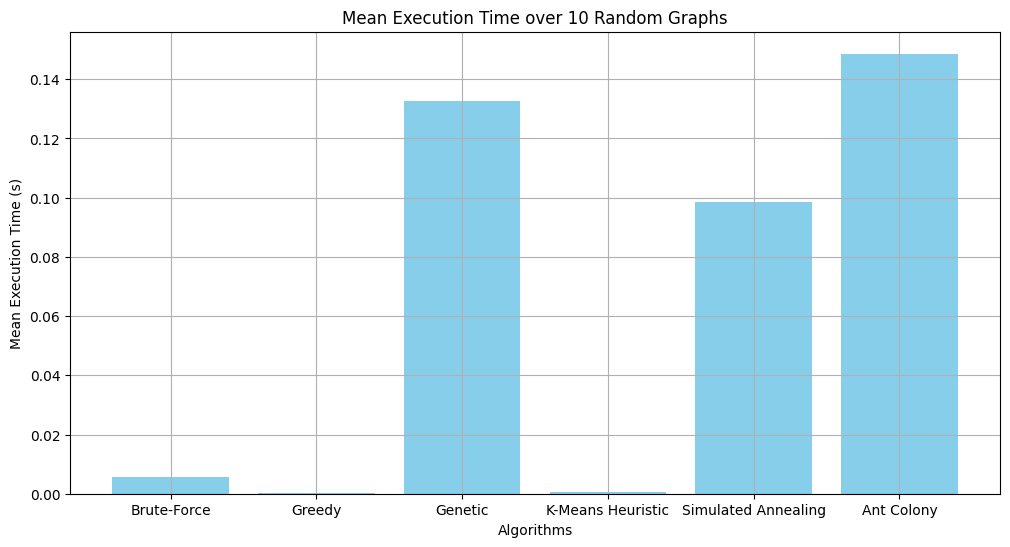

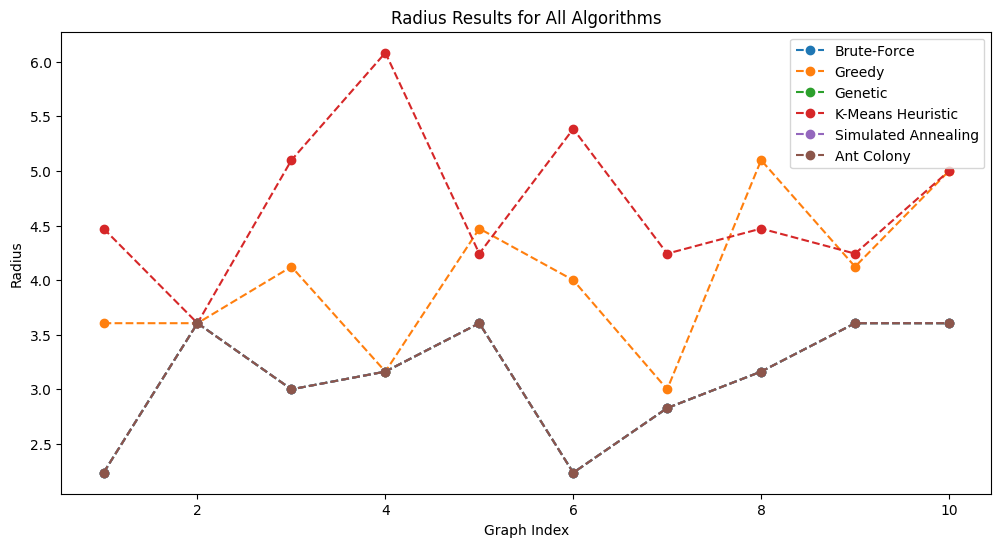


Plotting Time vs. Radius for Example 1...


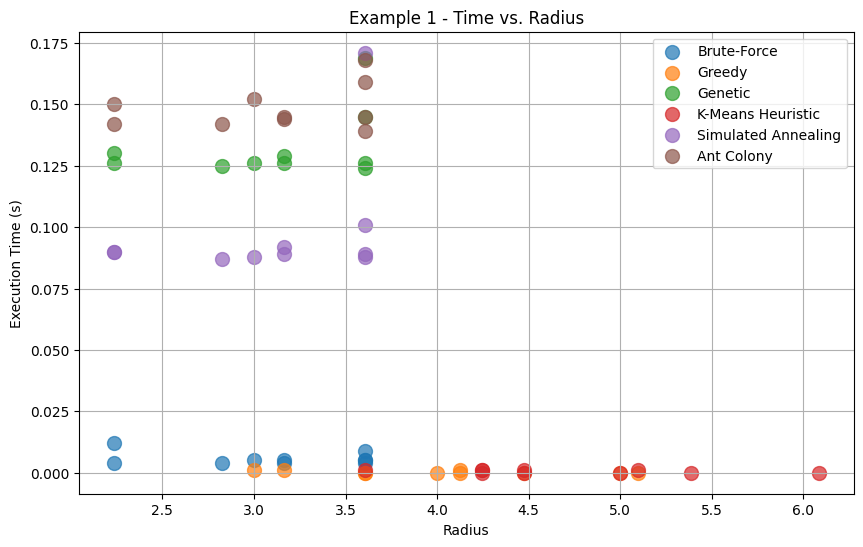


Example 1 Algorithm Performance Summary:
Brute-Force: Min Radius = 2.2361, Mean Radius = 3.1047, Mean Execution Time = 0.0057s, Score = 0.0562
Greedy: Min Radius = 3.0000, Mean Radius = 4.0191, Mean Execution Time = 0.0003s, Score = 0.5699
Genetic: Min Radius = 2.2361, Mean Radius = 3.1047, Mean Execution Time = 0.1326s, Score = 0.0651
K-Means Heuristic: Min Radius = 3.6056, Mean Radius = 4.6845, Mean Execution Time = 0.0005s, Score = 0.9438
Simulated Annealing: Min Radius = 2.2361, Mean Radius = 3.1047, Mean Execution Time = 0.0985s, Score = 0.0627
Ant Colony: Min Radius = 2.2361, Mean Radius = 3.1047, Mean Execution Time = 0.1486s, Score = 0.0662

Best Algorithm for Example 1 (Weighted by Time and Radius): Brute-Force


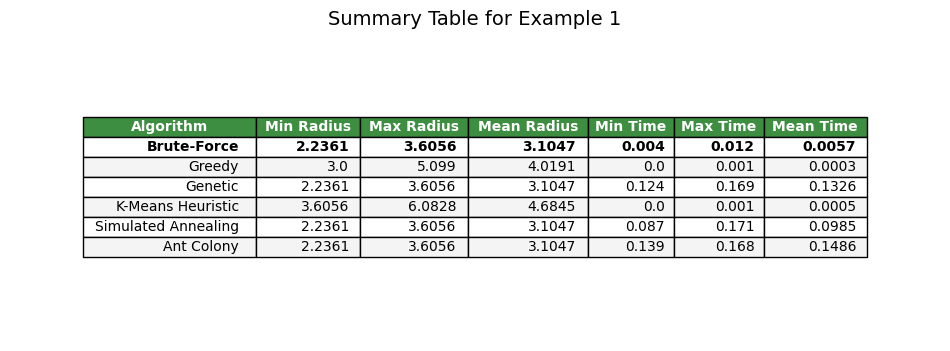

Visualizing the specific graph for Example 1...
Visualizing with Brute-Force...


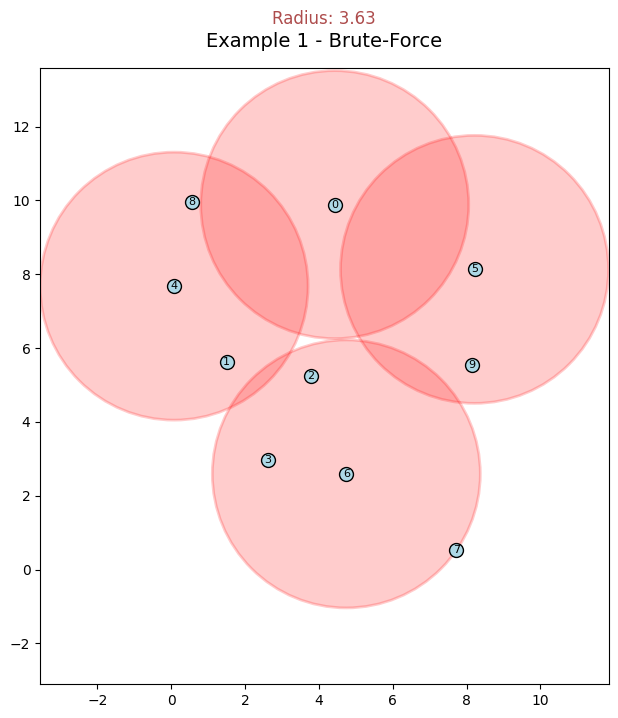

Visualizing with Greedy...


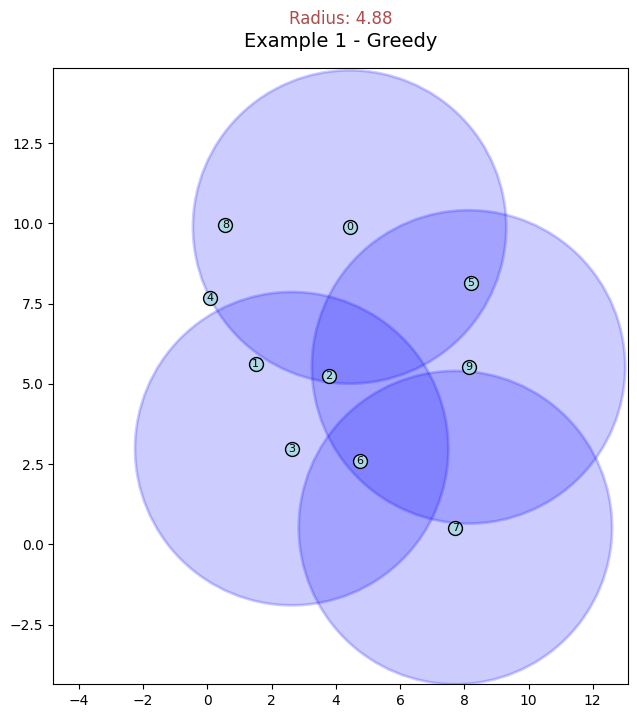

Visualizing with Genetic...


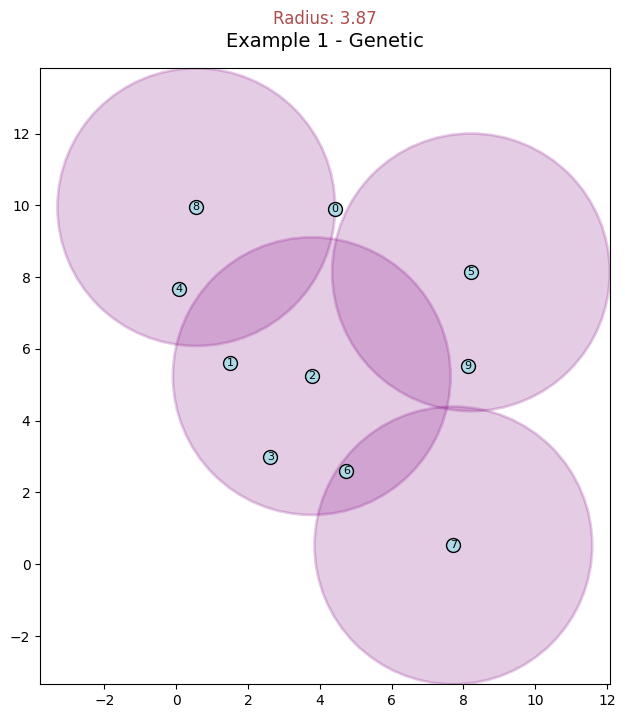

Visualizing with K-Means Heuristic...


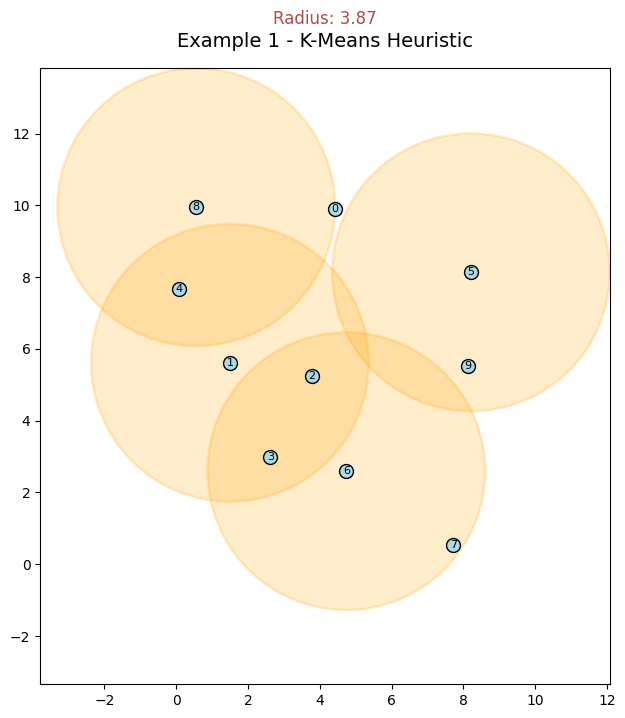

Visualizing with Simulated Annealing...


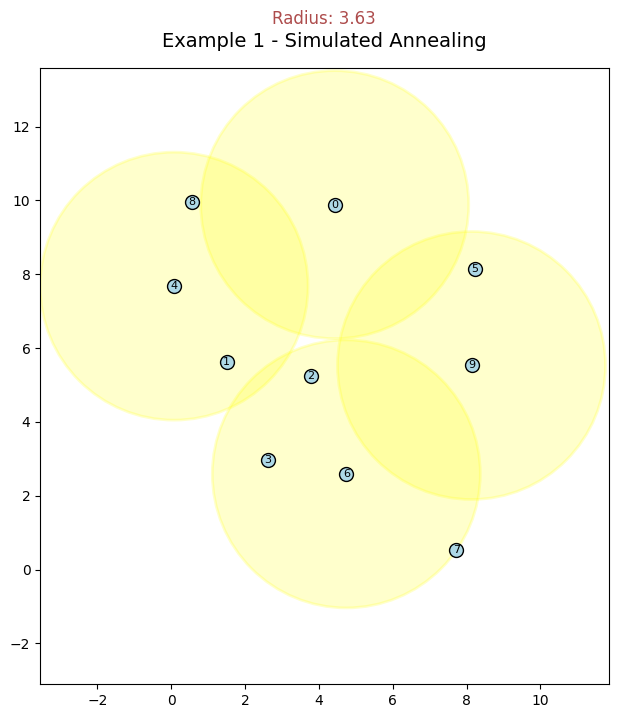

Visualizing with Ant Colony...


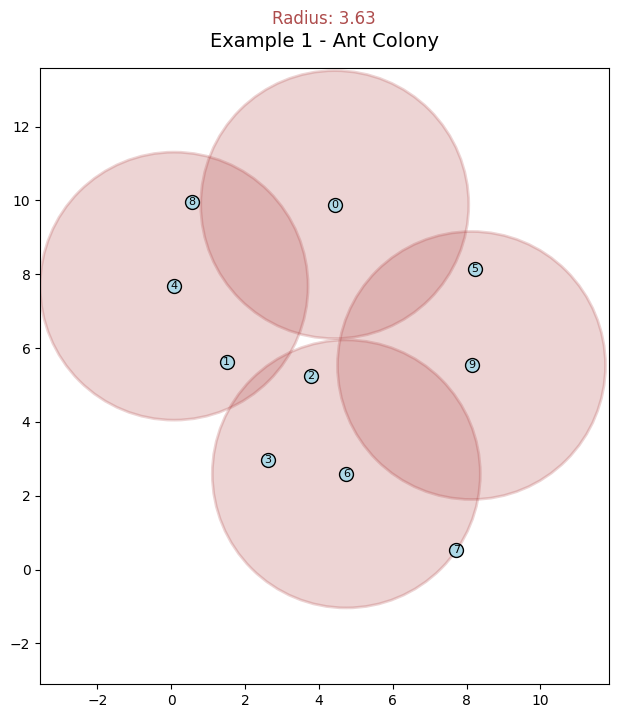


Running Example 2 with Parameters: {'num_graphs': 100, 'num_nodes': 15, 'k': 6, 'position_range': (0, 20)}


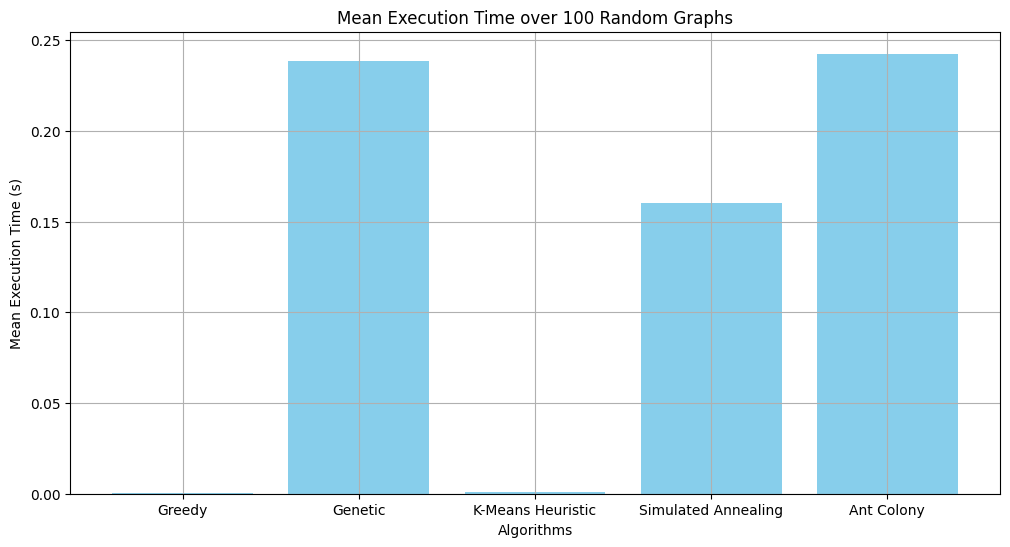

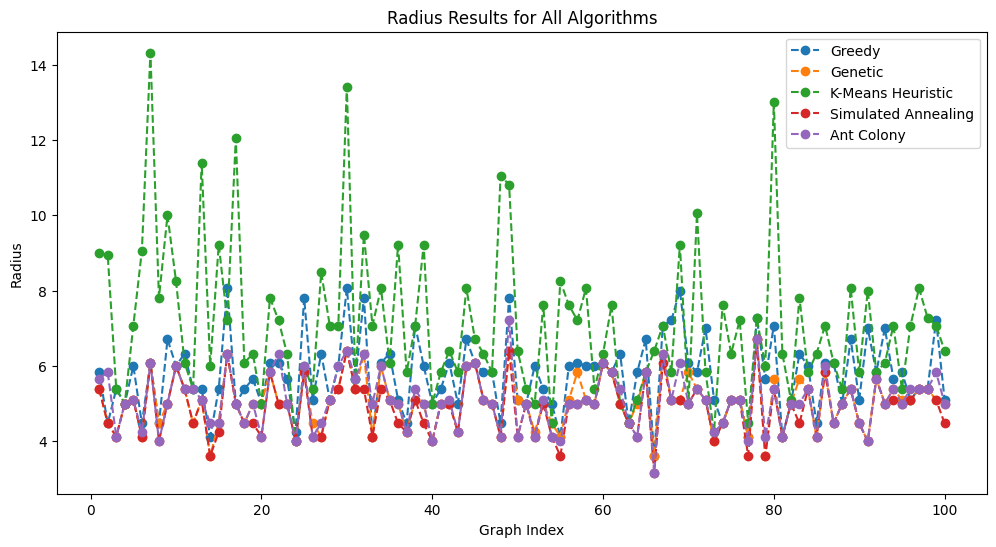


Plotting Time vs. Radius for Example 2...


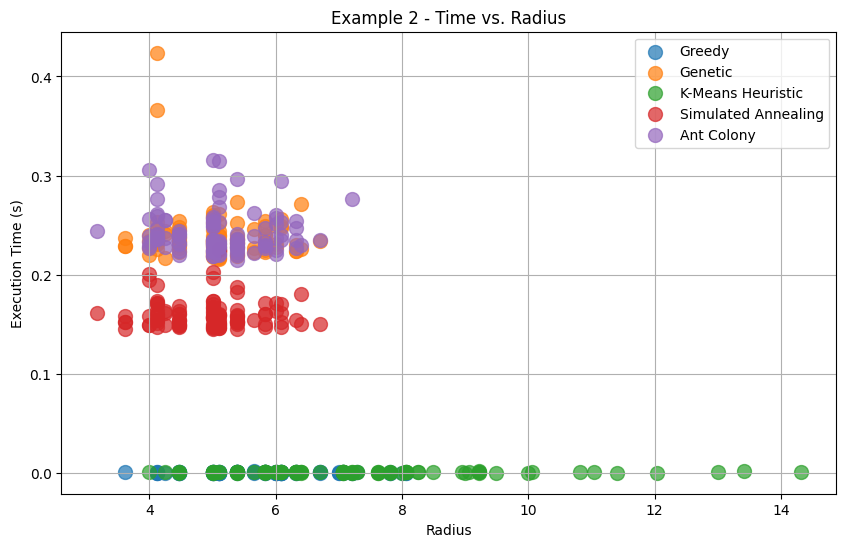


Example 2 Algorithm Performance Summary:
Greedy: Min Radius = 3.6056, Mean Radius = 5.7447, Mean Execution Time = 0.0006s, Score = 0.3931
Genetic: Min Radius = 3.6056, Mean Radius = 5.0390, Mean Execution Time = 0.2385s, Score = 0.0974
K-Means Heuristic: Min Radius = 4.0000, Mean Radius = 7.0928, Mean Execution Time = 0.0008s, Score = 0.9581
Simulated Annealing: Min Radius = 3.1623, Mean Radius = 4.9067, Mean Execution Time = 0.1606s, Score = 0.0419
Ant Colony: Min Radius = 3.1623, Mean Radius = 5.0815, Mean Execution Time = 0.2426s, Score = 0.1152

Best Algorithm for Example 2 (Weighted by Time and Radius): Simulated Annealing


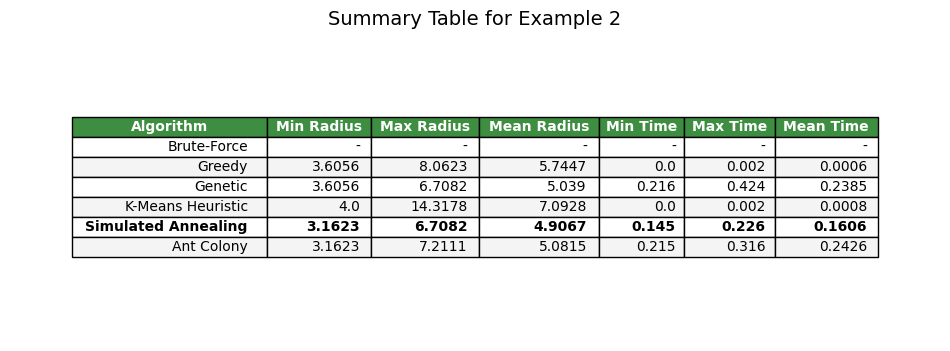

Visualizing the specific graph for Example 2...
Visualizing with Brute-Force...


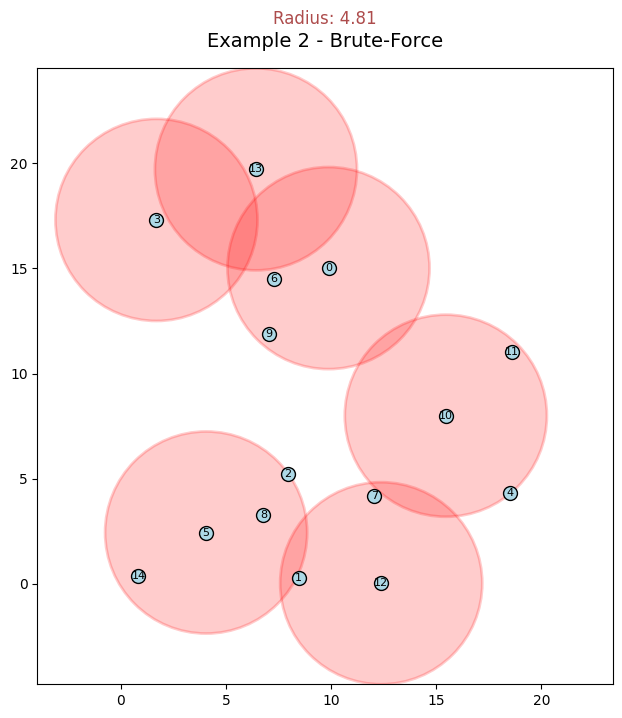

Visualizing with Greedy...


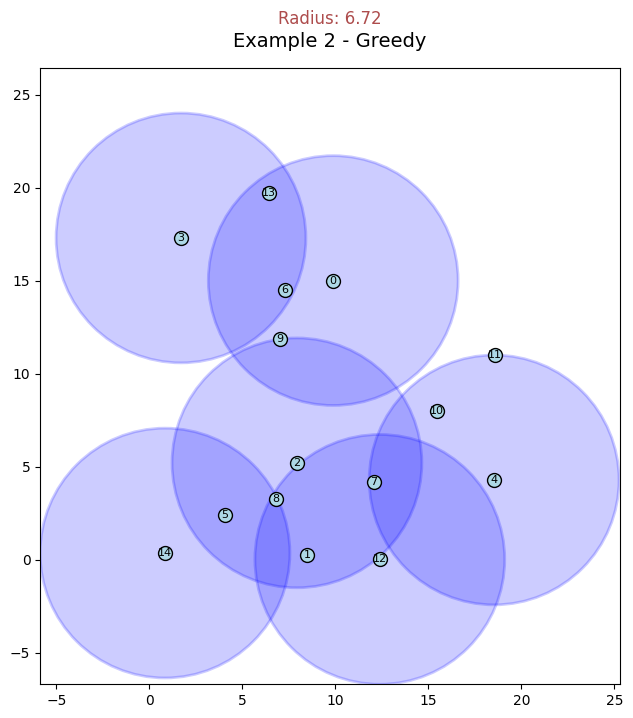

Visualizing with Genetic...


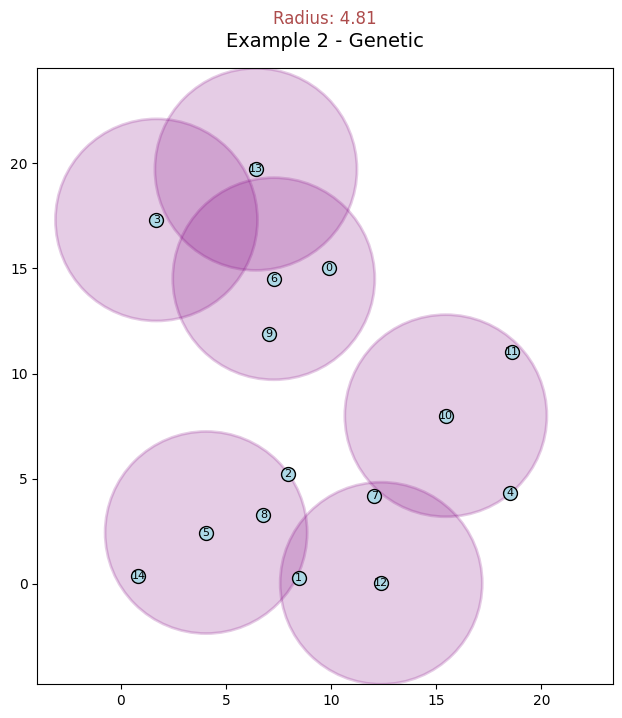

Visualizing with K-Means Heuristic...


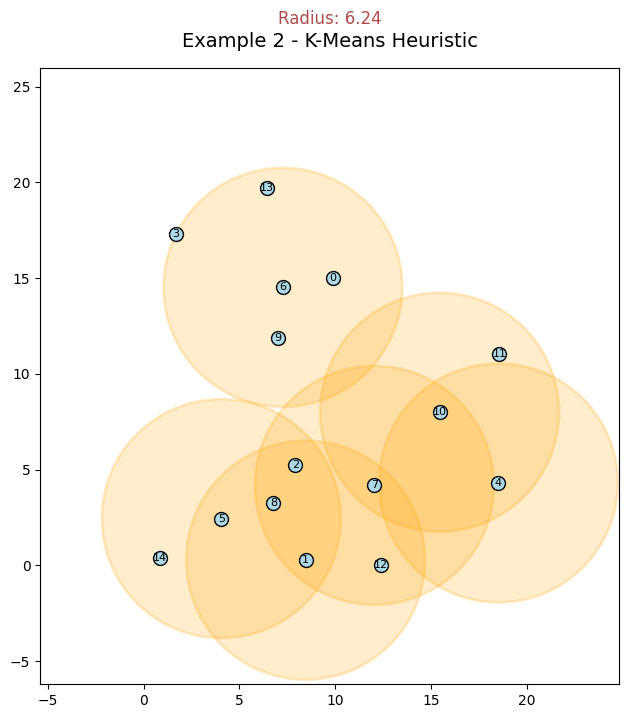

Visualizing with Simulated Annealing...


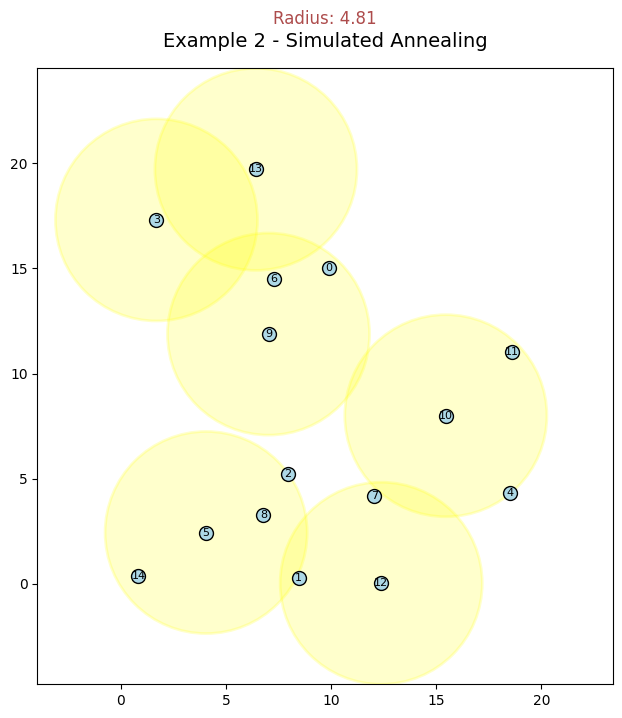

Visualizing with Ant Colony...


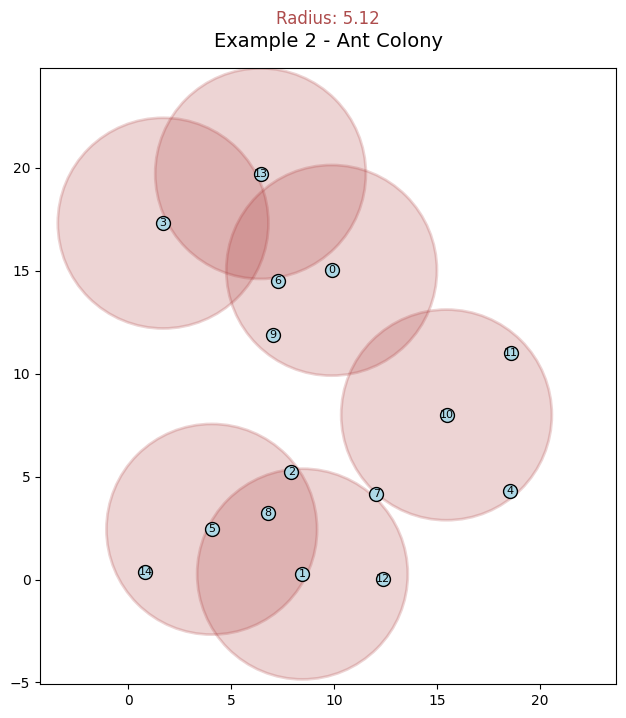


Running Example 3 with Parameters: {'num_graphs': 200, 'num_nodes': 20, 'k': 8, 'position_range': (0, 30)}


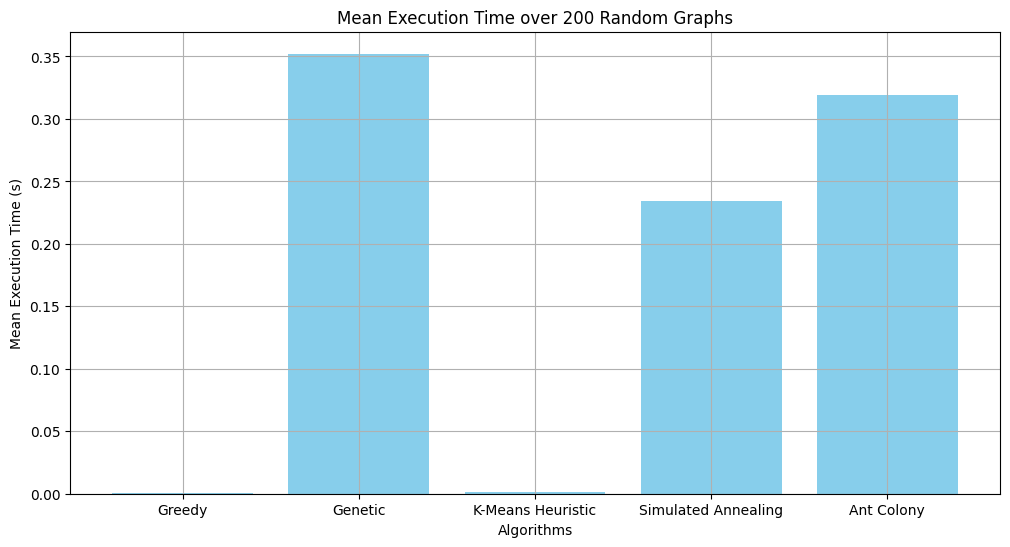

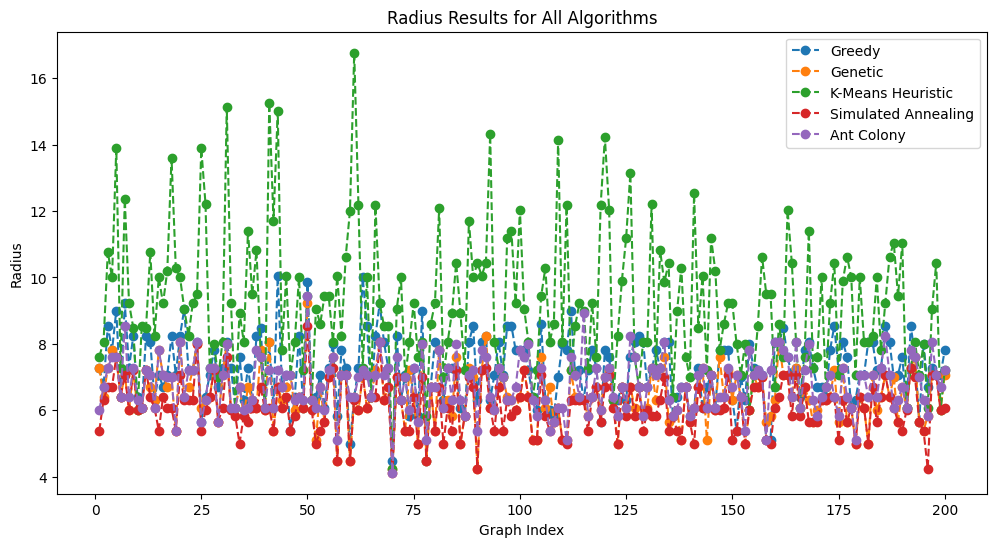


Plotting Time vs. Radius for Example 3...


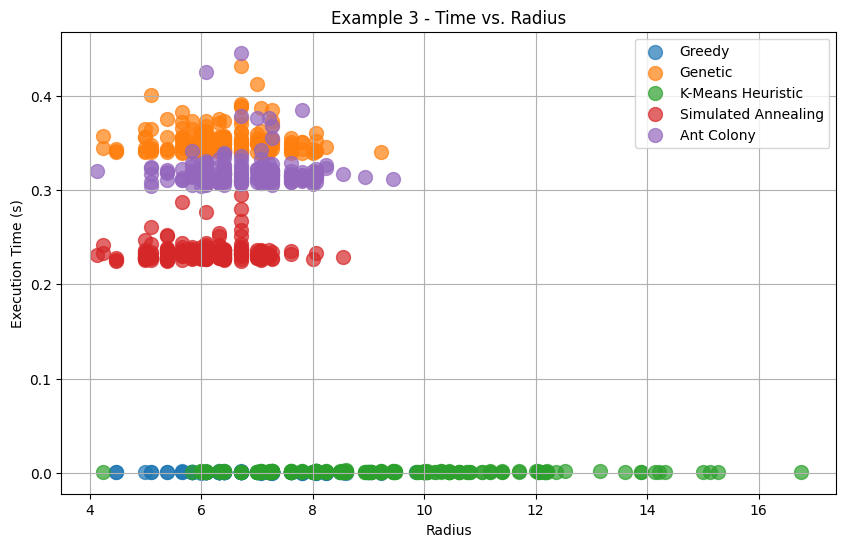


Example 3 Algorithm Performance Summary:
Greedy: Min Radius = 4.4721, Mean Radius = 7.2131, Mean Execution Time = 0.0010s, Score = 0.3650
Genetic: Min Radius = 4.2426, Mean Radius = 6.4613, Mean Execution Time = 0.3522s, Score = 0.1339
K-Means Heuristic: Min Radius = 4.2426, Mean Radius = 9.1796, Mean Execution Time = 0.0013s, Score = 0.9693
Simulated Annealing: Min Radius = 4.1231, Mean Radius = 6.1254, Mean Execution Time = 0.2341s, Score = 0.0307
Ant Colony: Min Radius = 4.1231, Mean Radius = 6.7787, Mean Execution Time = 0.3196s, Score = 0.2315

Best Algorithm for Example 3 (Weighted by Time and Radius): Simulated Annealing


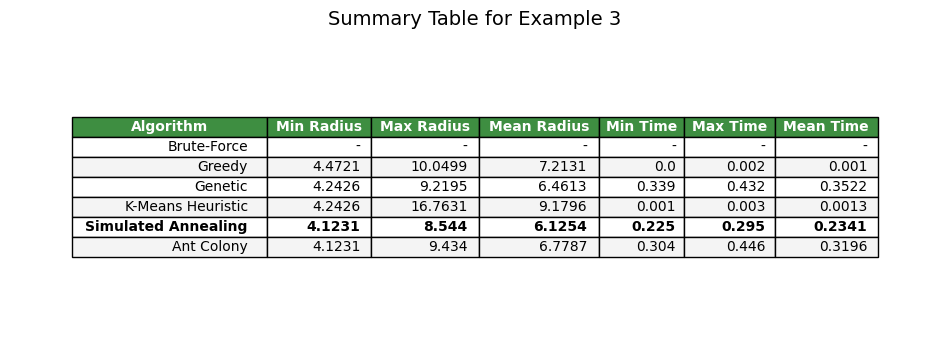

Visualizing the specific graph for Example 3...
Visualizing with Brute-Force...


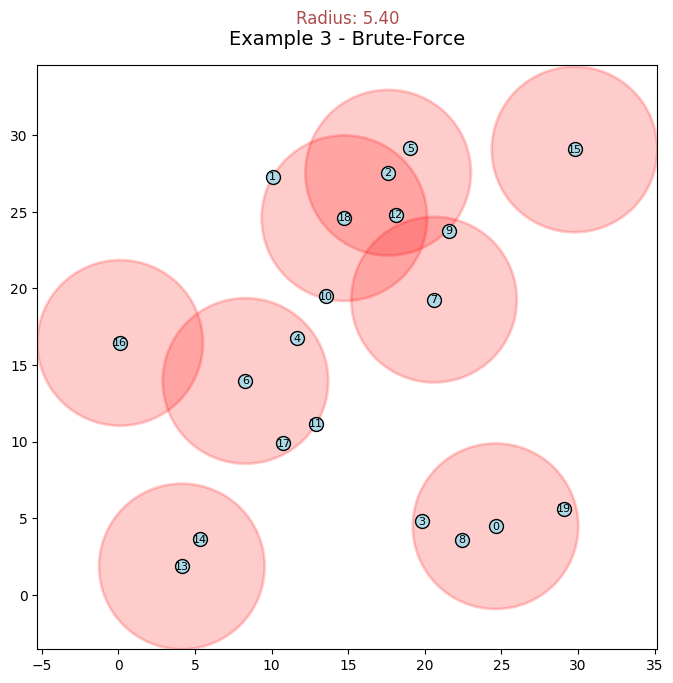

Visualizing with Greedy...


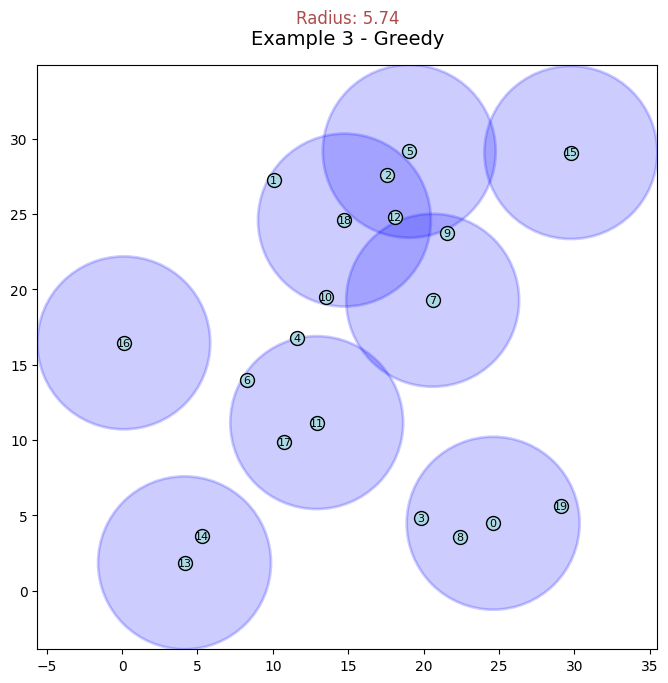

Visualizing with Genetic...


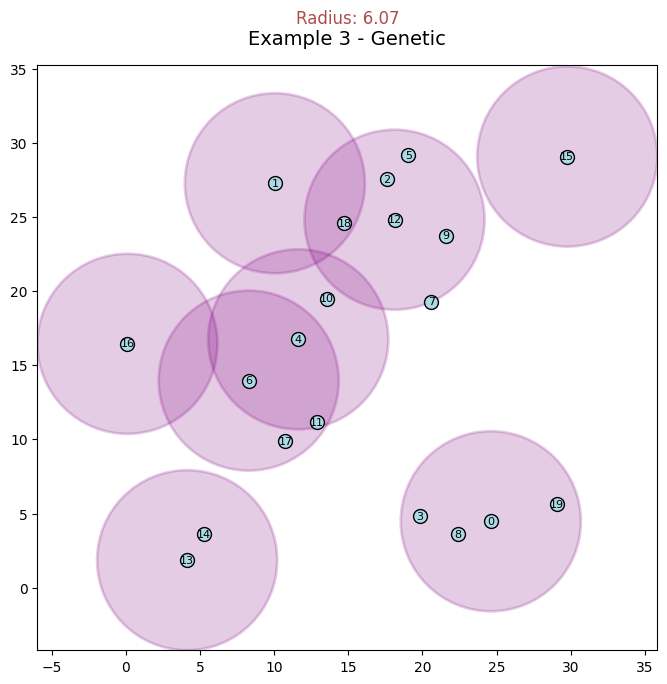

Visualizing with K-Means Heuristic...


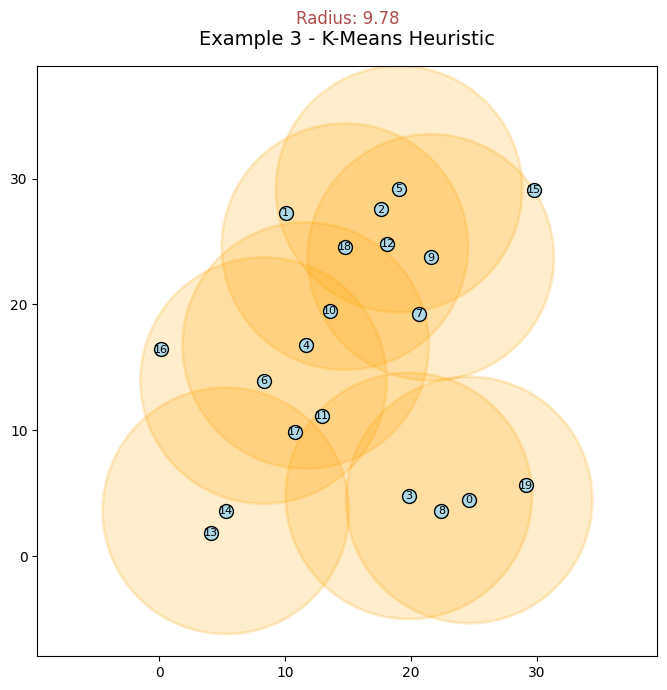

Visualizing with Simulated Annealing...


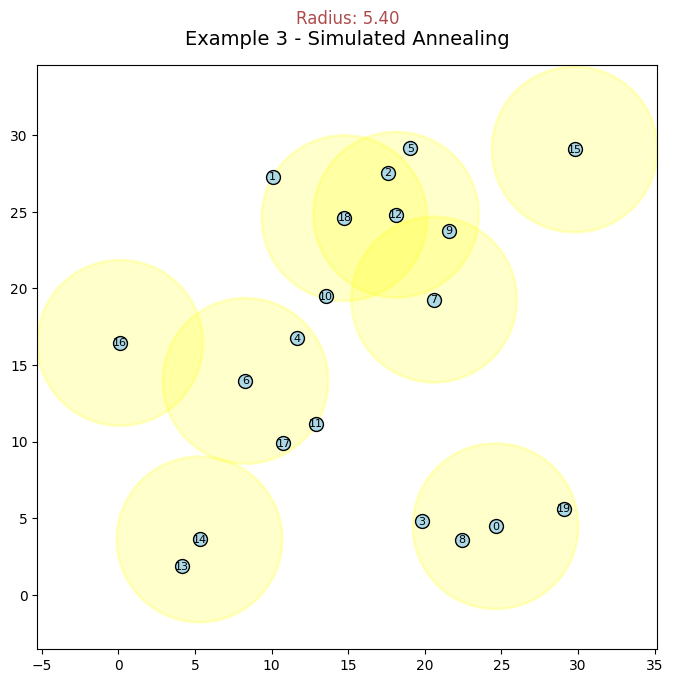

Visualizing with Ant Colony...


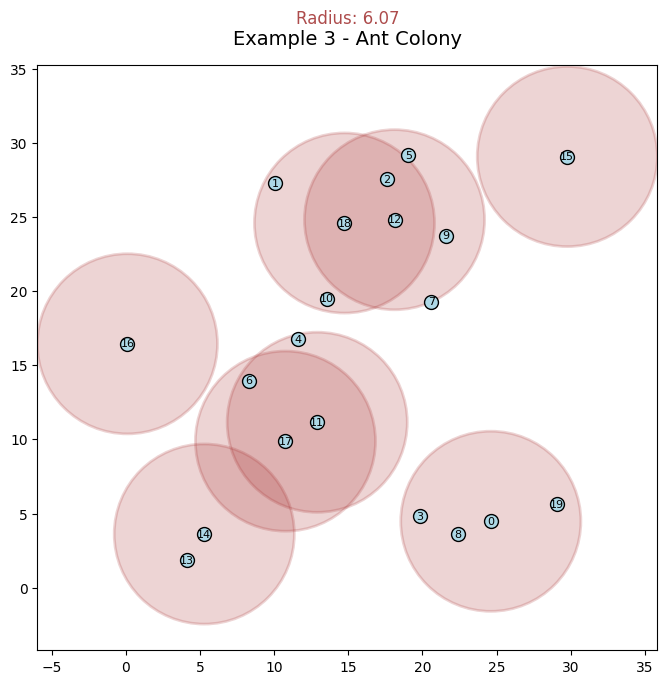

In [876]:
def main():
    # Define sets of parameters for three examples
    examples = [
        {"num_graphs": 10, "num_nodes": 10, "k": 4, "position_range": (0, 10)},
        {"num_graphs": 100, "num_nodes": 15, "k": 6, "position_range": (0, 20)},
        {"num_graphs": 200, "num_nodes": 20, "k": 8, "position_range": (0, 30)},
    ]

    # Define time limit for algorithms
    time_limit = 1

    example_positions = [
        [(4.42878431386921, 9.885654987213213), (1.498971150539402, 5.6116613620485625), (3.7781867153547055, 5.240832439390248), (2.6255783578055016, 2.982446582970548), (0.07754193921566843, 7.6781859059213), (8.214352616915727, 8.132231057026466), (4.742150972251813, 2.592263620605826), (7.723881006589073, 0.5238672066535033), (0.5609446843183796, 9.949375855829556), (8.132466590375078, 5.528738606248896)],
        [(9.87699151618122, 15.018792947526896), (8.461376921928593, 0.2669138208905397), (7.927890839372116, 5.217752898964571), (1.6933838084780173, 17.309963332596535), (18.52887598165468, 4.299616175853183), (4.056240499618768, 2.441101597928621), (7.273691764645587, 14.513493428087587), (12.055570347790074, 4.17645703029506), (6.776132186213914, 3.2555424636430397), (7.023372270175501, 11.879740230866426), (15.457726446250685, 7.996719229687777), (18.581943218734374, 11.014759414030697), (12.38361544755756, 0.02866267028984293), (6.424767970539953, 19.71652099972638), (0.8335881452378158, 0.36837390069712317)],
        [(24.613280755180593, 4.480285857772222), (10.056474706087343, 27.268132049334408), (17.604640321253044, 27.55606281478253), (19.818255264455715, 4.807157197344582), (11.63221873734969, 16.74603026737616), (19.04835640785252, 29.15222679107402), (8.292990878157138, 13.964533127066614), (20.601523583141574, 19.268248597097593), (22.415293993575517, 3.5921591378258344), (21.56348654899588, 23.742804535075372), (13.540588802735785, 19.493322288882585), (12.909812729386926, 11.154880647702589), (18.122851239564078, 24.8108487536737), (4.142420340010268, 1.854220512442012), (5.296435414036419, 3.6198838281346335), (29.769189290342783, 29.068983196255715), (0.11364025411012002, 16.44430048384541), (10.7681993151314, 9.882816359922357), (14.748970372460828, 24.588420784533945), (29.100233624533484, 5.633794064955605)]
    ]

    # Define algorithms
    algorithms = {
        "Brute-Force": brute_force_k_center,
        "Greedy": greedy_k_center,
        "Genetic": genetic_k_center,
        "K-Means Heuristic": k_means_heuristic,
        "Simulated Annealing": simulated_annealing_k_center,
        "Ant Colony": ant_colony_k_center,
    }

    # Define colors for each algorithm
    colors = {
        "Brute-Force": "red",
        "Greedy": "blue",
        "Genetic": "purple",
        "K-Means Heuristic": "orange",
        "Simulated Annealing": "yellow",
        "Ant Colony": "brown",
    }

    # Process each example
    for idx, params in enumerate(examples, start=1):
        print(f"\nRunning Example {idx} with Parameters: {params}")

        # Measure execution time and radius across random graphs
        execution_times, radius_results = measure_execution_time_and_radius_random_graphs(
            params["num_graphs"], params["num_nodes"], params["k"], algorithms, params["position_range"]
        )

        # Plot execution times (dual-axis for small and large times)
        plot_execution_times(execution_times, params["num_graphs"])

        # Plot radius results
        plot_radius_results(radius_results, params["num_graphs"])

        # Plot time vs radius for all algorithms
        print(f"\nPlotting Time vs. Radius for Example {idx}...")
        plot_time_vs_radius(execution_times, radius_results, title=f"Example {idx} - Time vs. Radius")

        # Calculate the best algorithm
        best_algorithm, scores = calculate_best_algorithm(radius_results, execution_times, time_limit)

        # Display the scores for each algorithm
        print(f"\nExample {idx} Algorithm Performance Summary:")
        for algo, score in scores.items():
            # If radius is empty or None, set it to infinity
            radius_values = radius_results[algo] if radius_results[algo] else [float('inf')]
            
            min_radius = min(radius_values)
            mean_radius = np.mean(radius_values)
            mean_time = np.mean(execution_times[algo])
    
            print(f"{algo}: Min Radius = {min_radius:.4f}, Mean Radius = {mean_radius:.4f}, "
                f"Mean Execution Time = {mean_time:.4f}s, Score = {score:.4f}")

        print(f"\nBest Algorithm for Example {idx} (Weighted by Time and Radius): {best_algorithm}")

        # Prepare a summary table with new parameters
        table_data = []

        for name in algorithms.keys():
            # If results are None (indicating failure), handle Brute-Force case
            if radius_results.get(name) is None or execution_times.get(name) is None:
                # Handle Brute-Force algorithm specifically
                if name == "Brute-Force":
                    # Skip it or fill with None values for Brute-Force
                    row = [name, None, None, None, None, None, None]
                else:
                    continue  # Skip other algorithms with None results
            else:
                # Check if radius results are empty
                if not radius_results[name]:  # If the list is empty
                    min_radius = max_radius = mean_radius = float('inf')
                else:
                    # Calculate the min, max, and mean values for radius
                    min_radius = round(min(radius_results[name]), 4)
                    max_radius = round(max(radius_results[name]), 4)
                    mean_radius = round(np.mean(radius_results[name]), 4)

                # Check if execution times are empty
                if not execution_times[name]:  # If the list is empty
                    min_time = max_time = mean_time = float('inf')
                else:
                    # Calculate the min, max, and mean values for time
                    min_time = round(min(execution_times[name]), 4)
                    max_time = round(max(execution_times[name]), 4)
                    mean_time = round(np.mean(execution_times[name]), 4)

                row = [name, min_radius, max_radius, mean_radius, min_time, max_time, mean_time]

            # Append row to the table data
            table_data.append(row)

        # Highlight the best algorithm in the entire row (not just the name)
        for i, row in enumerate(table_data):
            if row[0] == best_algorithm:
                # Highlight the entire row by making all values bold
                table_data[i] = [f"{value}" for value in row]

        # Plot the table as an image
        plot_table(table_data, f"Summary Table for Example {idx}", best_algorithm)        
        
        # Get specific positions from example positions
        specific_positions = example_positions[idx-1]

        # Visualize the specific graph for this example
        print(f"Visualizing the specific graph for Example {idx}...")
        graph = Graph(len(specific_positions), specific_positions)
        for name, algo in algorithms.items():
            print(f"Visualizing with {name}...")
            centers, radius = algo(graph, params["k"])
            visualize_graph(
                graph,
                centers,
                radius,
                f"Example {idx} - {name}",
                colors.get(name, "gray")  # Use the predefined color for the algorithm
            )

        
if __name__ == "__main__":
    main()